In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from dataclasses import dataclass
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

from diffuse.models.mlp2d import MLP2D
from diffuse.noise_scheduler import NoiseScheduler
from diffuse.data.simple import get_dataset
%load_ext autoreload
%autoreload 2

@dataclass
class Config:
    experiment_name: str = 'base'
    dataset: str = 'dino'
    train_batch_size: int = 128
    eval_batch_size: int = 1000
    num_epochs: int = 15
    learning_rate: float = 1e-3
    num_timesteps: int = 50
    beta_schedule: str = "log2"
    embedding_size: int = 128
    hidden_size: int = 128
    hidden_layers: int = 3
    time_embedding: str = "sinusoidal"
    input_embedding: str = "sinusoidal"
    save_images_step: int = 1

c = Config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training

In [16]:
device = torch.device('cpu')
dataset = get_dataset('moons')

dataloader = DataLoader(
    dataset, batch_size=c.train_batch_size, shuffle=True, drop_last=True)

model = MLP2D(
    hidden_size=c.hidden_size,
    hidden_layers=c.hidden_layers,
    emb_size=c.embedding_size,
    time_emb=c.time_embedding,
    input_emb=c.input_embedding).to(device)

noise_scheduler = NoiseScheduler(
    beta1=1e-4,
    beta2=.02,
    n_timesteps=c.num_timesteps,
    beta_schedule=c.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=c.learning_rate,
)

global_step = 0
losses = []
epoch_to_samples = dict()

print("Training model...")

for epoch in range(c.num_epochs):
    model.train()
    for step, batch in enumerate(dataloader):
        batch = batch[0]
        noise = torch.randn(batch.shape)
        timesteps = torch.randint(1, noise_scheduler.n_timesteps, (batch.shape[0],))
        
        noisy = noise_scheduler.add_noise(batch, timesteps, noise)
        noise_pred = model(noisy.to(device), timesteps.to(device))
        loss = F.mse_loss(noise_pred, noise.to(device))
        optimizer.zero_grad()
        loss.backward(loss)

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        losses.append(float(loss.detach().item()))

        if global_step % 300 == 0:
            loss = sum(losses[-30:])/min(30,len(losses)) # running loss
            print(f'e{epoch}|s{global_step} loss={loss:.2f}')

        global_step += 1

    if epoch % c.save_images_step == 0 or epoch == c.num_epochs - 1:
        epoch_to_samples[epoch]=noise_scheduler.sample(model, batch.shape)

## Sampling

(-6.0, 6.0)

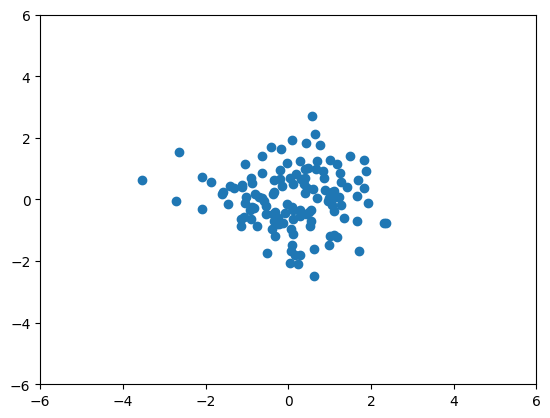

In [15]:
fig,ax = plt.subplots()
s = epoch_to_samples[14][0]
ax.scatter(s[:,0],s[:,1])
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)

(-6.0, 6.0)

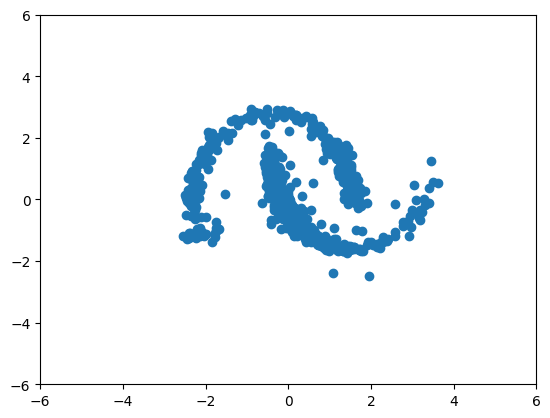

In [ ]:
fig,ax = plt.subplots()
s = epoch_to_samples[16][40]
ax.scatter(s[:,0],s[:,1])
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)

(-6.0, 6.0)

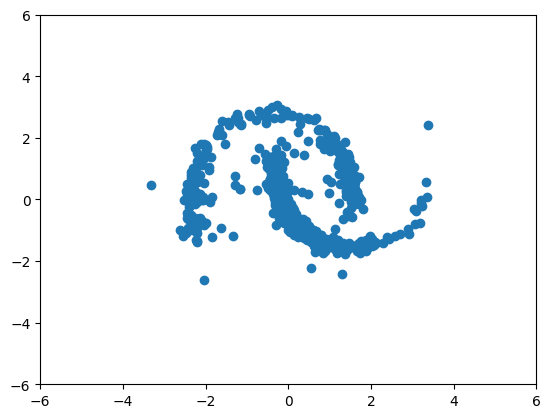

In [ ]:
fig,ax = plt.subplots()
s = epoch_to_samples[16][40]
ax.scatter(s[:,0],s[:,1])
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)

tensor([0.1880])